<img src="../data/unjust.jpg">
# **Chapter 3 | word2vec**
## **1 데이터 전처리**
[**word2vec matplotlib**](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne)

In [1]:
# ! apt-get update
# ! apt-get install g++ openjdk-8-jdk 
# ! pip3  install  nltk konlpy matplotlib gensim 

# ! apt-get install fonts-nanum-eco
# ! apt-get install fontconfig
# ! fc-cache -fv
# ! cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
# ! rm -rf /content/.cache/matplotlib/*

# script_text = "https://raw.githubusercontent.com/YongBeomKim/nltk_tutorial/master/data/movie_memories_of_murder_2003.txt"
# font_file = "/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/NanumGothicCoding.ttf"
script_text = "../data/movie_memories_of_murder_2003.txt"
font_file = "../data/D2Coding.ttf"

In [2]:
import matplotlib as mpl        
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_name   = fm.FontProperties(fname=font_file, size=10).get_name()
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_plot(model, figsize=(12,12)):
    "Creates and TSNE model and plots it"
    labels, tokens = [], []
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)

    tsne_model = TSNE(n_components=2)
    new_values = tsne_model.fit_transform(tokens)

    x, y = [], []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=figsize) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy = (x[i], y[i]),
                     fontsize=15)
#                      ha = 'right',
#                      va = 'bottom')
    plt.grid(True)
    plt.show()

In [4]:
# 텍스트를 줄단위로 끊어서 불러온뒤
# Token 단위로, 한글명사들을 추출한다
def txtnoun(sentences , skip=False, tags=['Noun'], stem=True, set_tokens=False):

    r"""
    살인의 추억 대본의 텍스트 전처리 작업을 진행합니다
    :param sentences: 단일한 Text String 데이터를 입력합니다
    :param skip: 분류된 Token 중 사용자가 원하는 형태로 변환된 내용을 출력
    :param tags: konlpy 로 분류된 품사중 추출하고자 하는 품사를 정의합니다
    :param stem: stemming 작업여부를 정의합니다.
    :param set_tokens: return 결과를 token list 객체로 출력할지를 정의합니다
    :return: set_tokens 내용에 따라 List, String 타입으로 출력합니다
    """
    
    import re
    from konlpy.tag import Okt
    twitter = Okt()
    result  = []
    sentences = sentences.replace('\n', '\n|')
    sentences = sentences.split('|')
    for content in sentences:
        texts      = content.replace('\n', '') # 해당줄의 줄바꿈 내용 제거
        tokenizer  = re.compile(r'[^ ㄱ-힣]+')  # 한글과 띄어쓰기를 제외한 모든 글자를 선택
        token_data = tokenizer.sub('', texts)  # 한글과 띄어쓰기를 제외한 모든 부분을 제거
        token_data = token_data.split(' ')
        sentence   = []

        for token in token_data:
            # skip 대상이 없을 떄
            if skip == False:
                chk_tok = twitter.pos(token, stem=stem)
                chk_tok = [temp[0]  for temp in chk_tok   if temp[1] in tags]
                ckeck   = "".join(chk_tok)
                if len(ckeck) > 1:
                    sentence.append(ckeck)

            # skip 내용이 있을 때
            else:
                if token.strip() in skip.keys():
                    result.append(skip[token.strip()])
                else:
                    chk_tok = twitter.pos(token, stem=stem)
                    chk_tok = [temp[0] for temp in chk_tok if temp[1] in tags]
                    ckeck   = "".join(chk_tok)

                    # 전처리가 끝난 결과가 skip에 해당여부 판단
                    if ckeck.strip() in skip.keys():
                        result.append(skip[ckeck.strip()])
                    elif len(ckeck) > 1:
                        sentence.append(ckeck)

        # 단락별 작업이 끝난 뒤 '\n'를 덧붙여서 작업을 종료
        temp = "".join(sentence)
        if len(temp) > 1:
            sentence = " ".join(sentence)
            sentence += "\n"
            result.append(sentence)

    if set_tokens == True:
        from nltk.tokenize import word_tokenize
        set_token = word_tokenize(" ".join(result))
        return list(set(set_token))

    else:
        return " ".join(result)

In [5]:
skips = {'두만':'박두만', '태윤':'서태윤', '용구':'조용구', '귀옥':'권귀옥', 
         '희봉':'구희봉', '동철':'신동철', '광호':'백광호', '병순':'조병순', 
         '해일':'박해일', '광호의':'백광호', '백광호의':'백광호'}

In [6]:
# import requests
# sentences = requests.get(script_text).text
# sentences[:300]

with open(script_text, 'r') as f:
    sentences = f.read()
sentences[:300]

'박두만\n서태윤\n조용구\n권귀옥\n구희봉\n신동철\n백광호20대 초반. 정박아\n조병순30대 후반. 변태성향\n박해일20대 초반. 공장 노동자. ‘유력한 용의자’.\n선본 남자, 동네 양아치들... 등등\n30대 초반의 전직 간호조무사, 마을 ‘야매주사’ 여인.\n안송여중 1학년 학생\n소현의 단짝 친구\n박보희, 이향숙, 독고현순, 박명자, 안미선.\n화면 가득 한 남자 아이의 얼굴이 보여진다.\n쏟아지는 햇살 아래, 맑은 눈빛의 아이는 카메라 정면을 응시하고 있다.\n아이는 코스모스 위에 앉아있는 잠자리를 향해 살며시 손을 뻗는다.\n휙~ 잠자리가 날아가 '

In [7]:
sentences   = txtnoun(sentences, skip=skips, tags=['Noun'])
script_file = 'script.txt'
with open(script_file, 'w', encoding='utf-8') as file:
    file.write(sentences)

In [8]:
%%time
from gensim.models import word2vec
data  = word2vec.LineSentence(script_file)
model = word2vec.Word2Vec(data, size=30, window=2, min_count=10, 
                          hs=1, workers=4, iter=100, sg=1)
model_file = "script.model"
model.save(model_file)

CPU times: user 1.5 s, sys: 80.6 ms, total: 1.58 s
Wall time: 1.7 s


<br/>
## **2 Word2Vec 모델의 활용**
모델을 활용하여 유력한 범인을 찾아보자!!

In [25]:
# 저장된 학습모델파일 불러오기
from gensim.models import word2vec
model_file = "script.model"
model = word2vec.Word2Vec.load(model_file)
len(model.wv.vocab.keys())

151

In [10]:
model.wv.vocab.keys()

dict_keys(['박두만', '서태윤', '조용구', '권귀옥', '구희봉', '백광호', '박해일', '용의자', '남자', '동네', '소현', '이향숙', '박명자', '화면', '가득', '아이', '얼굴', '아래', '눈빛', '카메라', '고개', '멀리', '점점', '소리', '모습', '머리', '인상', '형사', '박두', '여자', '시체', '후레쉬', '순간', '위로', '거기', '뭔가', '주위', '브래지어', '너머', '순경', '바람', '시작', '표정', '마주', '서로', '시선', '보고', '음악', '취조실', '사무실', '계속', '사진', '바로', '부분', '사람', '갑자기', '분위기', '얘기', '저녁', '어디', '다시', '아저씨', '진짜', '정말', '새끼', '문득', '저기', '한번', '구석', '피해자', '시점', '책상', '주변', '사건', '현장', '여기', '지금', '간다', '참깨밭', '발자국', '하나', '발견', '근처', '반장', '듯이', '잔뜩', '다리', '스타킹', '설영', '자기', '가방', '조그만', '그냥', '그게', '그거', '잠시', '목소리', '가운데', '팬티', '임마', '끄덕', '그대로', '똑바로', '잠깐', '모두', '다른', '경찰', '코피', '휴지', '누군가', '운동화', '라디오', '권기옥', '자리', '장님', '우리', '생각', '버럭', '아무', '기억', '서서히', '서류', '훈련', '불빛', '의경', '자신', '당신', '전경', '범인', '이건', '신문', '방송', '조심스레', '빗줄기', '빗소리', '어둠속', '우산', '그림자', '빗물', '학교', '변소', '사이', '괴남자', '인부', '조병순', '언덕', '언덕집', '조각', '기차', '유전자', '총구'])

<br></br>
## **4 Word2Vec 모델 내용 확인**
모델을 활용하여 유력한 범인을 찾아보자!!

In [11]:
# 범인과 관련된 내용 중 사람이름이 안나옴...
model.wv.most_similar('범인', topn=10)

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('우리', 0.7759134769439697),
 ('얘기', 0.6490262150764465),
 ('변소', 0.647366464138031),
 ('거기', 0.63503098487854),
 ('그냥', 0.5989676117897034),
 ('그거', 0.5813127160072327),
 ('학교', 0.5636203289031982),
 ('여기', 0.5422303676605225),
 ('사건', 0.5189334154129028),
 ('저기', 0.513542890548706)]

In [12]:
# 현장과 가장 가깝게 등장한 인물이 1명 등장
model.wv.most_similar('현장', topn=10)

[('사진', 0.7380123734474182),
 ('용의자', 0.6944419145584106),
 ('사건', 0.6879351735115051),
 ('참깨밭', 0.6677441000938416),
 ('이향숙', 0.6263526082038879),
 ('시점', 0.5875036716461182),
 ('얼굴', 0.5674402117729187),
 ('발자국', 0.5540725588798523),
 ('동네', 0.5488398671150208),
 ('박명자', 0.5294669270515442)]

In [26]:
# 현장 과 백광호 와 밀접한 증거들 중에 방해가 되는 내용을 찾는다
model.wv.most_similar(['현장','이향숙'], topn=10)

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('참깨밭', 0.7733044624328613),
 ('사진', 0.7212710380554199),
 ('근처', 0.6643168330192566),
 ('사건', 0.6573654413223267),
 ('발자국', 0.6432328224182129),
 ('바로', 0.5992716550827026),
 ('얼굴', 0.5892413854598999),
 ('용의자', 0.5844476222991943),
 ('박명자', 0.5729365944862366),
 ('동네', 0.5683016777038574)]

In [27]:
# 현장 과 백광호 와 밀접한 증거들 중에 방해가 되는 내용을 찾는다
model.wv.most_similar(['현장', '백광호'], topn=10)

[('얼굴', 0.7912280559539795),
 ('사진', 0.767784833908081),
 ('용의자', 0.7620895504951477),
 ('참깨밭', 0.6409595608711243),
 ('사건', 0.6381074786186218),
 ('발자국', 0.6283285021781921),
 ('이향숙', 0.5980838537216187),
 ('시점', 0.5819774270057678),
 ('박두만', 0.558142900466919),
 ('운동화', 0.5340201258659363)]

In [28]:
# 현장 과 백광호 와 밀접한 증거들 중에 '참깨밭' 이 계속 방해가 됨
# 참깨밭에 백광호가 밀접하게 연결되어 있어서 이를 제외한 분석이 필요
model.wv.most_similar(['현장','백광호'], negative=['참깨밭'], topn=15)

[('얼굴', 0.7406951189041138),
 ('용의자', 0.7300146222114563),
 ('똑바로', 0.6524434089660645),
 ('사진', 0.6250198483467102),
 ('눈빛', 0.5850471258163452),
 ('시점', 0.5387791991233826),
 ('아래', 0.5301571488380432),
 ('그대로', 0.5078673362731934),
 ('다리', 0.5067879557609558),
 ('서태윤', 0.5048905611038208),
 ('박두만', 0.4771198630332947),
 ('표정', 0.4762386679649353),
 ('서류', 0.46344584226608276),
 ('보고', 0.46289002895355225),
 ('총구', 0.4553548991680145)]

In [29]:
# 현장 과 백광호 와 밀접한 증거들 중에 '참깨밭' 이 계속 방해가 됨
# 참깨밭에 백광호와 이향숙을 제외한 분석이 필요
model.wv.most_similar(['현장','백광호'], negative=['참깨밭','이향숙'], topn=20)

[('똑바로', 0.4933473765850067),
 ('시작', 0.4580173194408417),
 ('눈빛', 0.4426656663417816),
 ('아래', 0.44175711274147034),
 ('다리', 0.4386548697948456),
 ('그대로', 0.4127076268196106),
 ('보고', 0.41134607791900635),
 ('용의자', 0.4005204141139984),
 ('서태윤', 0.3976595401763916),
 ('취조실', 0.36349913477897644),
 ('박해일', 0.3568190038204193),
 ('총구', 0.3495206832885742),
 ('얼굴', 0.3166359066963196),
 ('구희봉', 0.3108248710632324),
 ('갑자기', 0.2946508526802063),
 ('서류', 0.2866917550563812),
 ('시점', 0.27620065212249756),
 ('기차', 0.2676546573638916),
 ('언덕', 0.2652484178543091),
 ('조용구', 0.25703179836273193)]

<br></br>
## **5 Visulaization**
gensim

In [17]:
vocab = list(model.wv.vocab)
X     = model[vocab]

/home/markbaum/Python/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [18]:
from sklearn.manifold import TSNE
tsne   = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X)

In [19]:
import pandas as pd
df = pd.DataFrame(X_tsne, index=vocab, columns=['x','y'])
df.head()

,x,y
박두만,-0.157505,-3.205210
서태윤,-0.202696,-3.248582
조용구,0.185217,-4.017589
권귀옥,1.016865,-5.406393
구희봉,0.621423,-5.207854


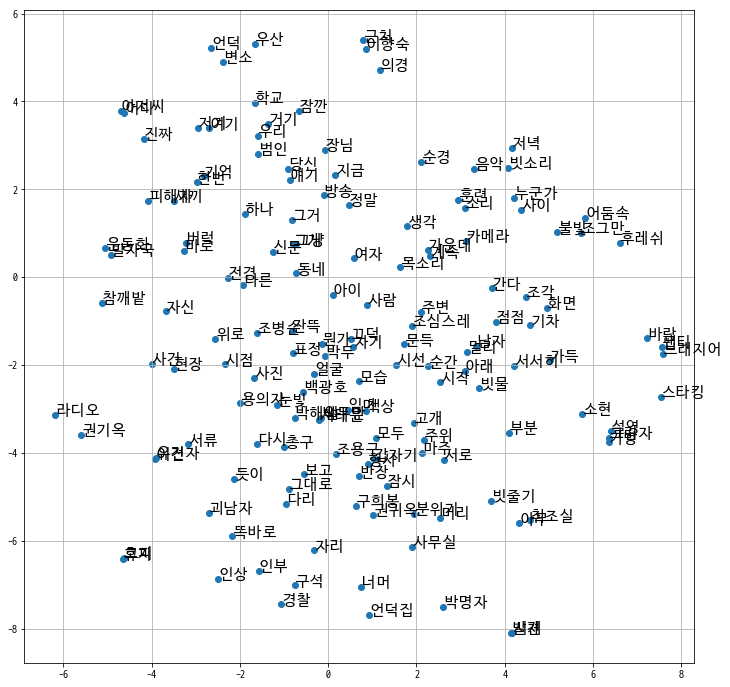

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
fig  = plt.figure(figsize=(12,12))
ax   = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=15)
plt.grid(True)

/home/markbaum/Python/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


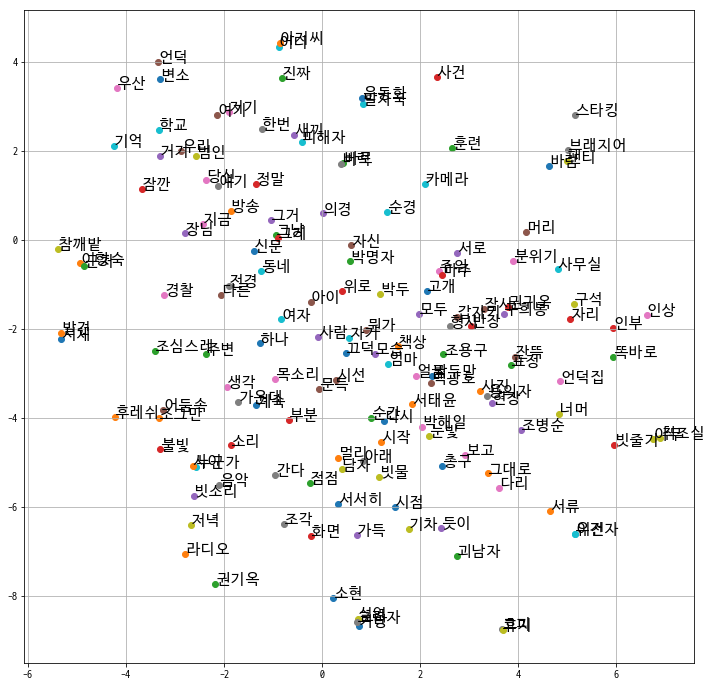

In [21]:
tsne_plot(model)

<br></br>
## **6 결과의 해석 및 활용**
1. 유사관계, 반대관계로 **출력된 모든 Token들이 가치가 있지는 않다**
1. **min_count, Vector 갯수** 2가지 조건만 사용하여 모델을 생성한다
1. Word2Vec 도 **문서를 분석하는 도구**에 불과 (절대적 **가치를 창출하는 기법** 으로 오해 X)
1. 해당 분야의 **잘 정리된 Document로 학습한 Word2Vec 모델** 에서 **유의미 한 token 들의 관계** 를 Template으로 잘 정리
1. 분석대상 문서를 **유사한 조건으로 word2vec 모델** 을 만들고, **앞에서 정리된 Template와** 비교하여 결과
다듬기
1. 시나리오의 분석 경우
    1. 결과물 중 인물의 Token 만 활용하여 분석
    1. 결과물 중 증거물의 Token 만 활용하여 분석
    1. 결과물 중 장소의 Token 만 활용하여 분석

In [22]:
# model 에 등장하는 인물들
charator = ["박두만", "서태윤", "조용구", "권귀옥", "구희봉", "신동철", "백광호",
            "조병순", "박해일", "박보희", "이향숙", "독고현순", "박명자", "안미선", 
            "반장", "소현", "범인", "형사", '괴남자', '순경','피해자', '권기옥','용의자']

In [23]:
# model 에 등장하는 장소명 들
area = ['현장', '사무실', '취조실', '변소', '참깨밭', '빗줄기', '어둠속', '언덕집']

In [24]:
# model 에 등장하는 Item 들
items = ['브래지어', '팬티', '우산', '운동화', '스타킹', '목소리', '불빛', '음악', '후레쉬', 
         '카메라', '라디오', '방송', '유전자', '가방', '코피', '휴지', '신문', '총구']